In [1]:
import numpy as np
import os
import sys
import warnings
import time

# Define paths to relevant modules
measure_sampling_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling"
)
trees_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees"
)
Benchmark_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Benchmark_value_Gausian"
)
awd_trees_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AWD_trees"
)
CD_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Conditional_density"
)
kmeans_meas_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Adapted_empirical_measure"
)
aot_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics"
)

# Add paths to sys.path
for path in [
    measure_sampling_path,
    trees_path,
    Benchmark_path,
    awd_trees_path,
    CD_path,
    kmeans_meas_path,
    aot_path,
]:
    if path not in sys.path:
        sys.path.append(path)

from Build_trees_from_paths import *
from Tree_Node import *
from TreeAnalysis import *
from TreeVisualization import *
from Save_Load_trees import *
from Tree_AWD_utilities import *
from Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared
from Gurobi_AOT import *
from Nested_Dist_Algo import compute_nested_distance
from CD_nonparam import *

from Gen_Path_and_AdaptedTrees import *
from mainfunctions import *
from measure import *
from normal_ot import *
from FVI_bench import *

from Extract_Sample_path_AOT import extract_sample_paths

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from AEM_kMeans import (
    empirical_k_means_measure,
    empirical_k_means_measure_new,
    empirical_k_means_measure_grid,
)
from AEM_grid import empirical_grid_measure

In [ ]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define common parameters
scale1 = 1
scale2 = 0.5
init_a, init_b = 1, 2
use_weights = 1
n_runs = 10

# Define the methods and time steps to loop over
method = "kmeans"

# Define sample path sizes for each time step
num_paths = 2000

time_steps = 6

bm1_root, _ = generate_adapted_tree(
    num_paths=num_paths,
    time_steps=time_steps,
    x_init=init_a,
    scale=scale1,
    use_weights=use_weights,
    model="brownian",
    return_times=True,
    cluster_method=method,
)
bm2_root, _ = generate_adapted_tree(
    num_paths=num_paths,
    time_steps=time_steps,
    x_init=init_b,
    scale=scale2,
    use_weights=use_weights,
    model="brownian",
    return_times=True,
    cluster_method=method,
)

In [ ]:
# Compute the nested (adapted optimal transport) distance and timing
max_depth = get_depth(bm1_root)
start_time = time.time()
distance_pot = compute_nested_distance(
    bm1_root,
    bm2_root,
    max_depth,
    method="solver_lp_pot",
    return_matrix=False,
    lambda_reg=0,
    power=2,
)
elapsed_time_pot = time.time() - start_time

# Adjust distance by subtracting the initial difference in squares (if needed)
distance_pot -= (init_a - init_b) ** 2

print("time:")
print(elapsed_time_pot)
print("distance:")
print(distance_pot)

In [2]:
import torch
from CD_knn_NerualNet import train_conditional_density


def my_build_tree_cde(T, init, samplepath_x, device, in_sample_size, n_iter):
    """
    Builds a tree of depth T (i.e. T transitions, T+1 time steps) using:
      - KMeans clustering for the first transition (t == 0), and
      - A conditional density estimator (CDE) for subsequent transitions.

    For t == 0:
      - Cluster the values at time 1 (from samplepath_x) using KMeans with in_sample_size clusters.
      - Use the cluster centers as support points and the relative frequency counts as probabilities.
      - Create children by adding these support points to the root's value.

    For t > 0:
      - Train a CDE using data from time t to t+1 extracted from samplepath_x.
      - For each node, evaluate the estimator at the node's value to obtain support points.
      - Create children by shifting the parent's value by these increments and assign uniform weights.

    Parameters:
      - T (int): Number of transitions (tree depth).
      - init (float): Initial value at the root.
      - samplepath_x (np.ndarray): Array of i.i.d. sample paths (shape: [num_paths, time_steps]).
      - device: PyTorch device.
      - in_sample_size (int): Parameter for KMeans (at t==0) and number of atoms for the CDE.
      - n_iter (int): Number of iterations for training the CDE.

    Returns:
      - TreeNode: The root of the constructed tree.
    """
    # Create the root node.
    root = TreeNode(init)
    current_level = [root]

    # Loop over transitions/time steps.
    for t in range(T - 1):
        if t == 0:
            # For the first transition, use KMeans clustering on the values at time 1.
            samples = samplepath_x[:, t + 1].reshape(-1, 1)  # shape: (num_paths, 1)
            kmeans = KMeans(n_clusters=in_sample_size, n_init=10).fit(samples)
            centers = np.squeeze(
                kmeans.cluster_centers_, axis=1
            )  # shape: (in_sample_size,)
            # Calculate probabilities based on cluster counts.
            _, counts = np.unique(kmeans.labels_, return_counts=True)
            probs = counts / np.sum(counts)
        else:
            # For t > 0, train the conditional density estimator using data from time t to t+1.
            X = np.expand_dims(samplepath_x[:, t], axis=1)  # shape: (num_paths, 1)
            Y = np.expand_dims(samplepath_x[:, t + 1], axis=1)  # shape: (num_paths, 1)
            data = np.concatenate([X, Y], axis=1)  # shape: (num_paths, 2)
            data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
            x_estimator, x_loss_hist, x_n_nan = train_conditional_density(
                data_tensor,
                d_X=1,
                d_Y=1,
                k=in_sample_size,
                n_iter=n_iter,
                n_batch=50,
                lr=1e-3,
                nns_type=" ",
                Lip=True,
            )

        next_level = []
        # Process each node in the current level.
        for node in current_level:
            if t == 0:
                # For t == 0, use the KMeans centers as the support points.
                support_points = centers
                for i, child_val in enumerate(support_points):
                    child_node = TreeNode(child_val)
                    node.add_child(child_node, probs[i])
                    next_level.append(child_node)
            else:
                # For t > 0, evaluate the CDE at the current node.
                x_estimator.atomnet.to(device)
                x_estimator.atomnet.eval()
                with torch.no_grad():
                    node_tensor = torch.tensor(
                        [[node.value]], dtype=torch.float32, device=device
                    )
                    x_atoms = x_estimator.atomnet(
                        node_tensor
                    ).squeeze()  # shape: (in_sample_size,)
                support_points = x_atoms.cpu().numpy()
                # Assume a uniform probability over the support points.
                prob = 1.0 / support_points.shape[0]
                for child_val in support_points:
                    child_node = TreeNode(child_val)
                    node.add_child(child_node, prob)
                    next_level.append(child_node)

        current_level = next_level

    return root

In [3]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define common parameters
scale1 = 1
scale2 = 0.5
init_a, init_b = 1, 2
use_weights = 1
n_runs = 10

# Define sample path sizes for each time step
num_paths = 3000

time_steps = 6


pot_times = []
final_result_pot = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for n in range(n_runs):

    sample_path_1 = generate_brownian_motion(
        num_paths=num_paths,
        time_steps=time_steps,
        x_init=init_a,
        scale=scale1,
        return_time=False,
    )
    sample_path_2 = generate_brownian_motion(
        num_paths=num_paths,
        time_steps=time_steps,
        x_init=init_b,
        scale=scale2,
        return_time=False,
    )

    tree1_root = my_build_tree_cde(
        T=6,
        init=init_a,
        samplepath_x=sample_path_1,  # sample_path_2 should be a NumPy array of shape [num_paths, time_steps]
        device=device,
        in_sample_size=2,
        n_iter=650,
    )

    tree2_root = my_build_tree_cde(
        T=6,
        init=init_b,
        samplepath_x=sample_path_2,
        device=device,
        in_sample_size=2,
        n_iter=650,
    )

    max_depth = get_depth(tree1_root)
    start_time = time.time()
    distance_pot = compute_nested_distance(
        tree1_root,
        tree2_root,
        max_depth,
        method="solver_lp_pot",
        return_matrix=False,
        lambda_reg=0,
        power=2,
    )
    elapsed_time_pot = time.time() - start_time

    # Adjust distance by subtracting the initial difference in squares (if needed)
    distance_pot -= (init_a - init_b) ** 2

    final_result_pot.append(distance_pot)
    pot_times.append(elapsed_time_pot)
    print(f"    POT Distance: {distance_pot:.4f}  Time: {elapsed_time_pot:.2f}s")


mean_pot = np.mean(final_result_pot)
std_pot = np.std(final_result_pot)

mean_pot_time = np.mean(pot_times)
print("  POT mean (std) =", f"{mean_pot:.4f} ({std_pot:.4f})")
print("  POT avg time   =", f"{mean_pot_time:.3f}")

Training took 6.02 seconds.
Number of NaN losses encountered: 117
Training took 4.35 seconds.
Number of NaN losses encountered: 50
Training took 4.43 seconds.
Number of NaN losses encountered: 54
Training took 4.56 seconds.
Number of NaN losses encountered: 15
Training took 4.66 seconds.
Number of NaN losses encountered: 68
Training took 4.59 seconds.
Number of NaN losses encountered: 42
Training took 4.87 seconds.
Number of NaN losses encountered: 22
Training took 5.15 seconds.
Number of NaN losses encountered: 0
    POT Distance: 6.0625  Time: 0.06s
Training took 4.49 seconds.
Number of NaN losses encountered: 0
Training took 4.66 seconds.
Number of NaN losses encountered: 0
Training took 4.46 seconds.
Number of NaN losses encountered: 36
Training took 4.44 seconds.
Number of NaN losses encountered: 30
Training took 4.29 seconds.
Number of NaN losses encountered: 78
Training took 4.39 seconds.
Number of NaN losses encountered: 39
Training took 4.17 seconds.
Number of NaN losses encou

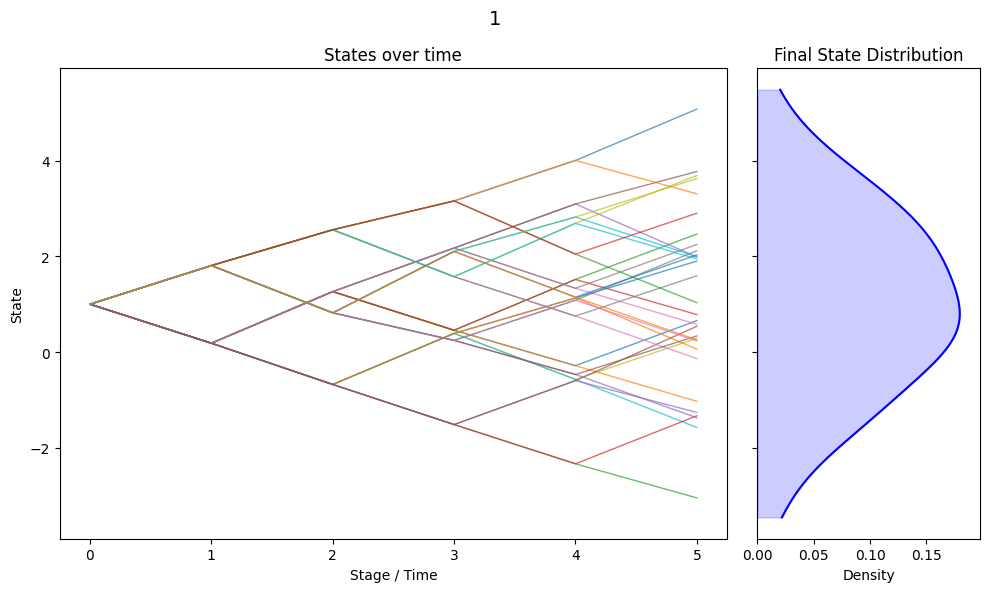

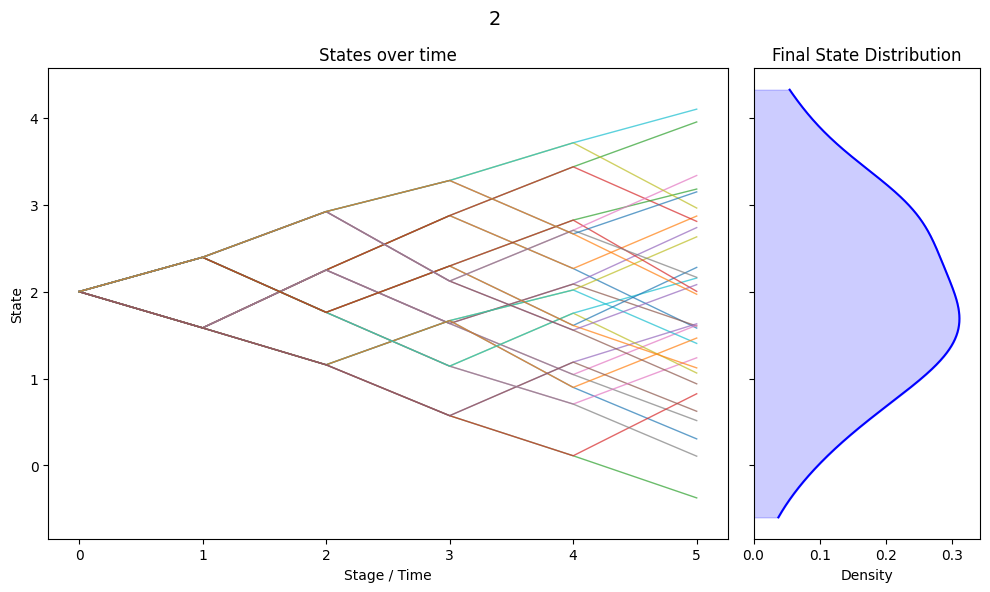

    POT Distance: 8.6000  Time: 0.08s


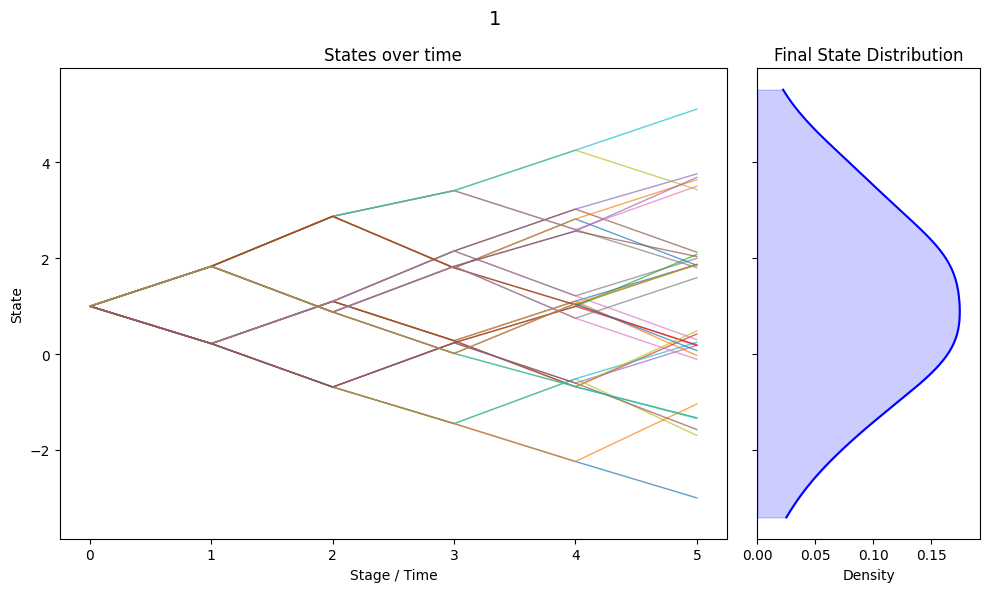

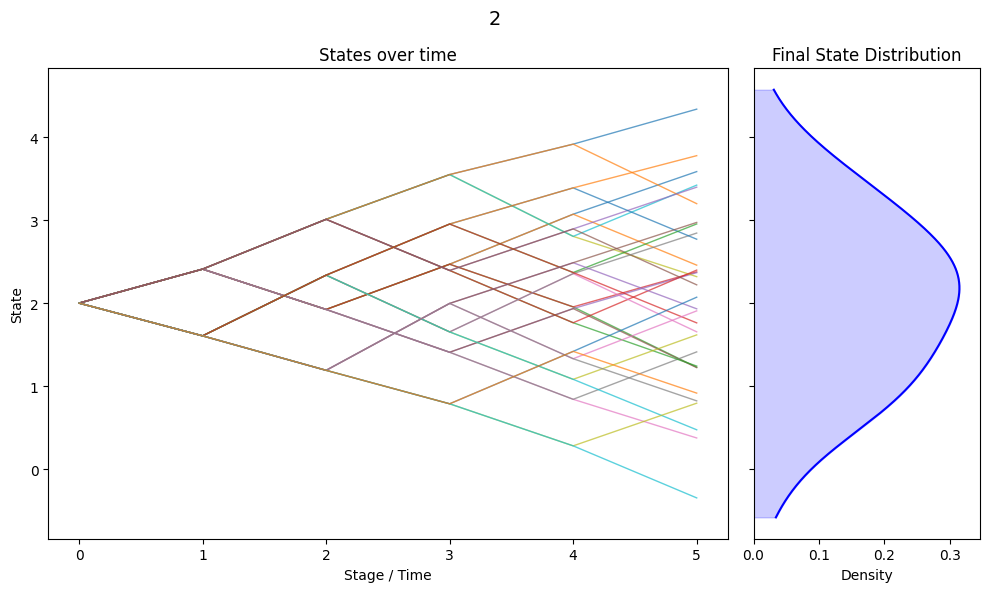

    POT Distance: 9.2049  Time: 0.06s


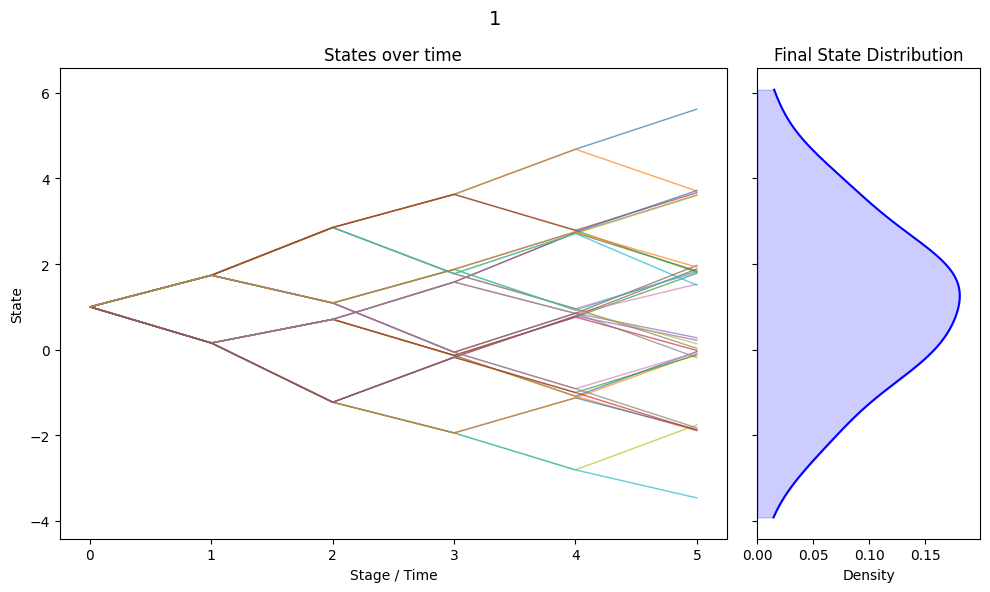

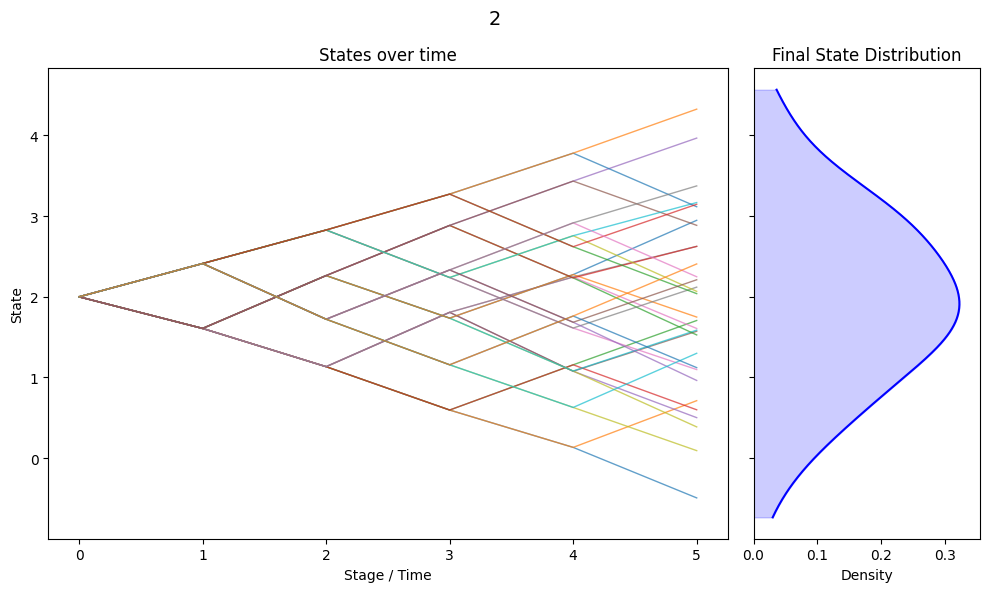

    POT Distance: 9.0214  Time: 0.06s


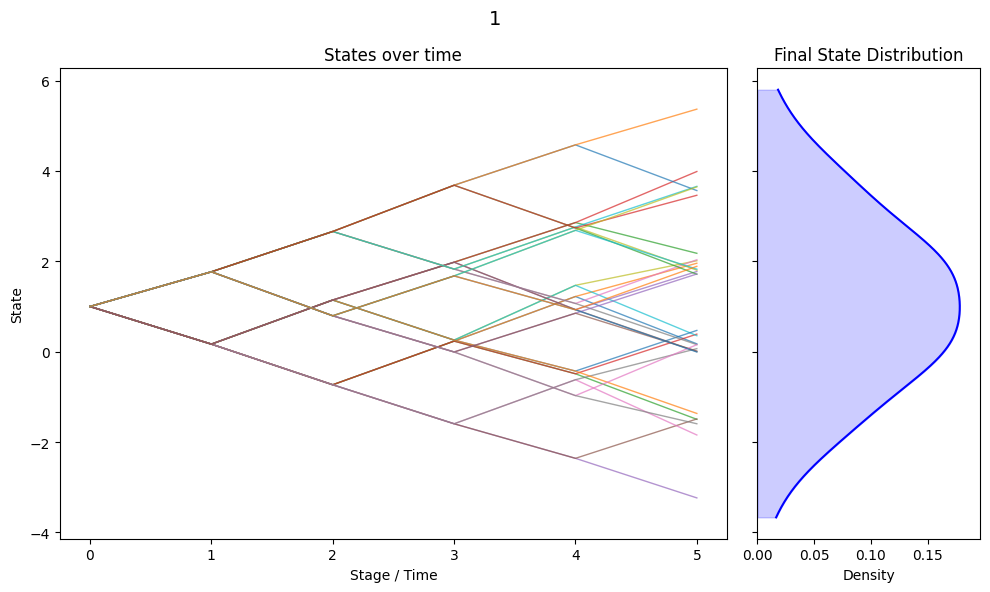

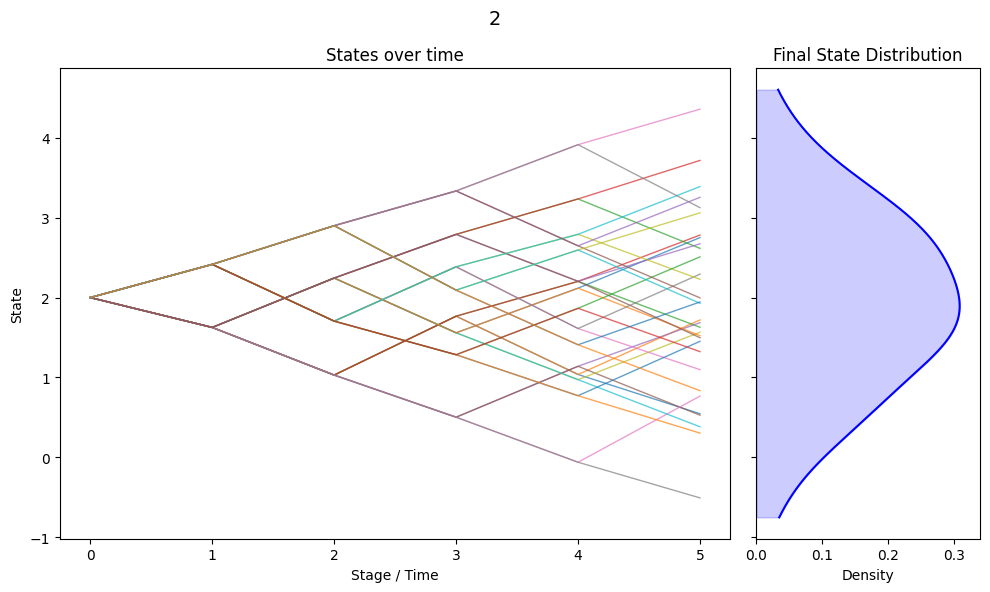

    POT Distance: 7.4735  Time: 0.05s


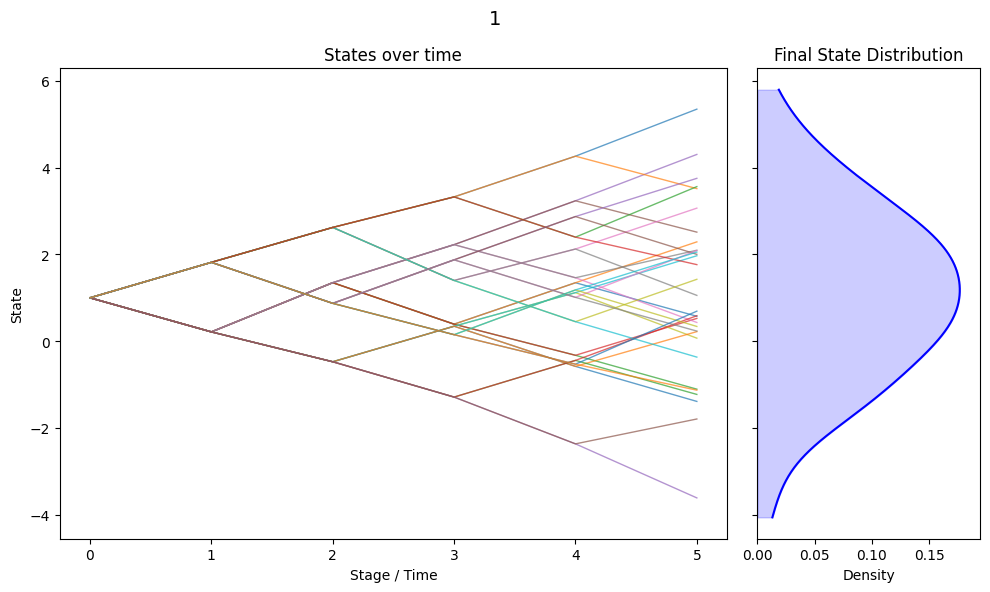

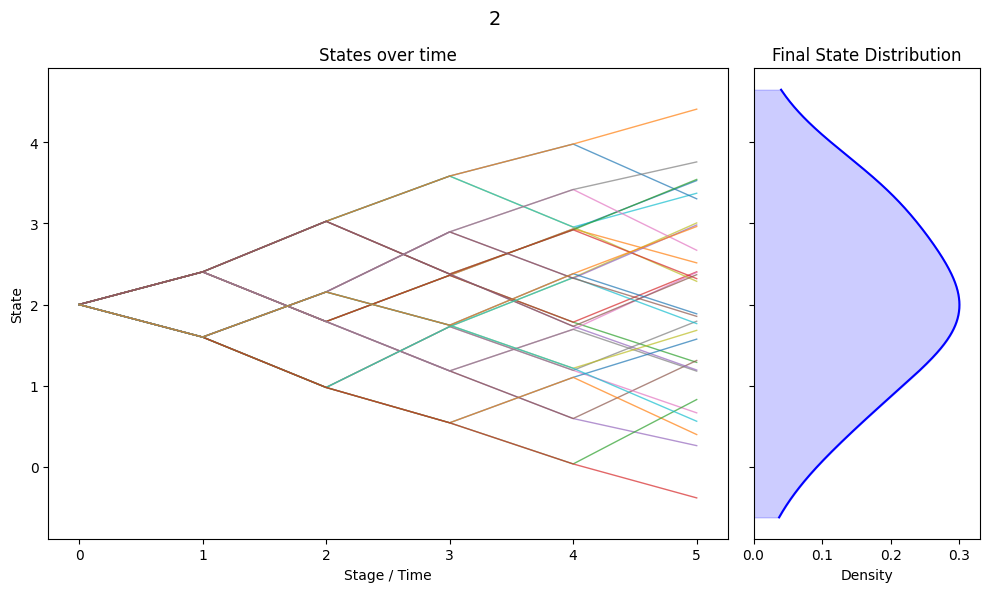

    POT Distance: 8.4815  Time: 0.05s


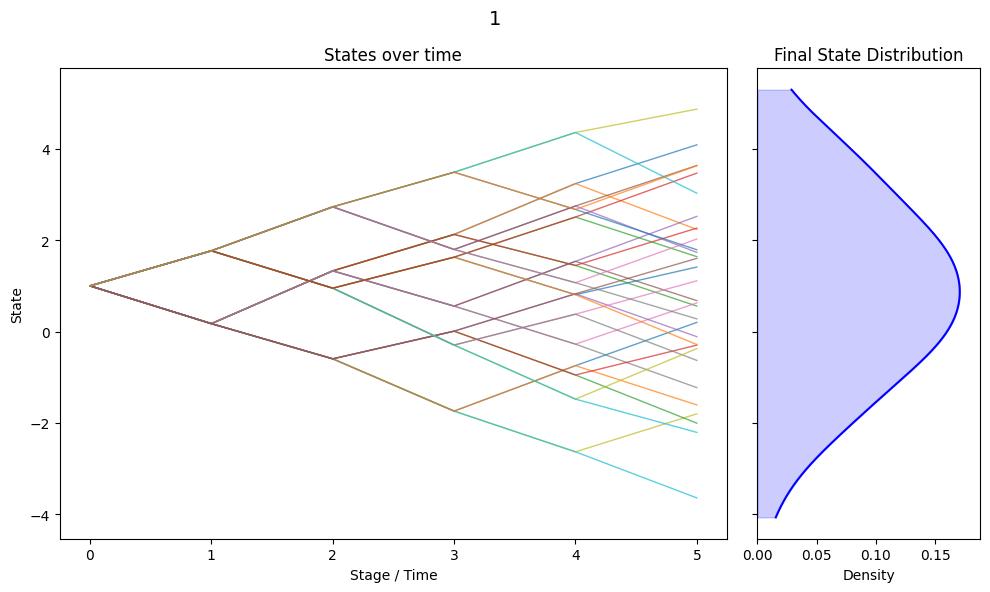

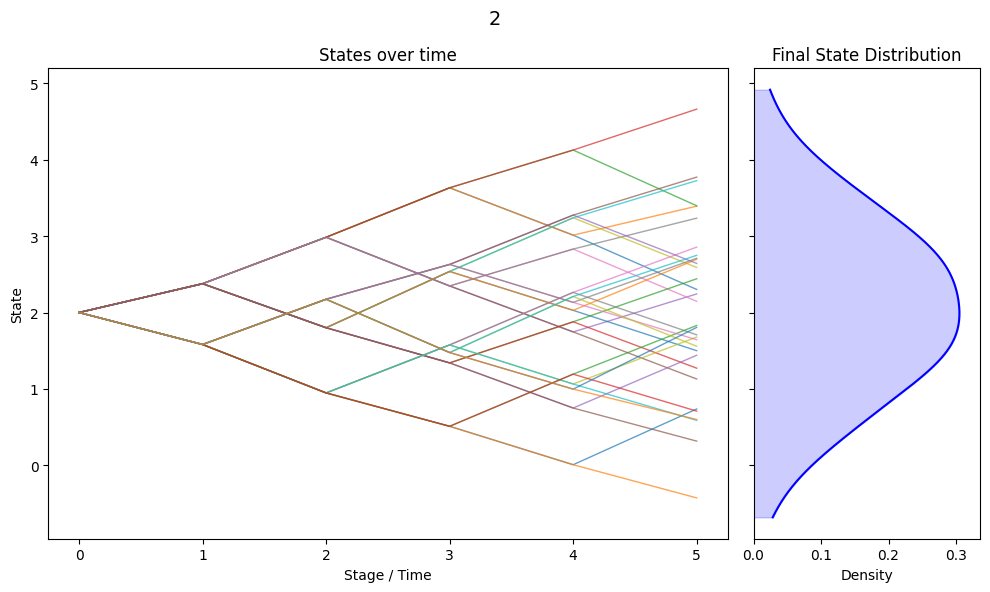

    POT Distance: 9.7150  Time: 0.06s


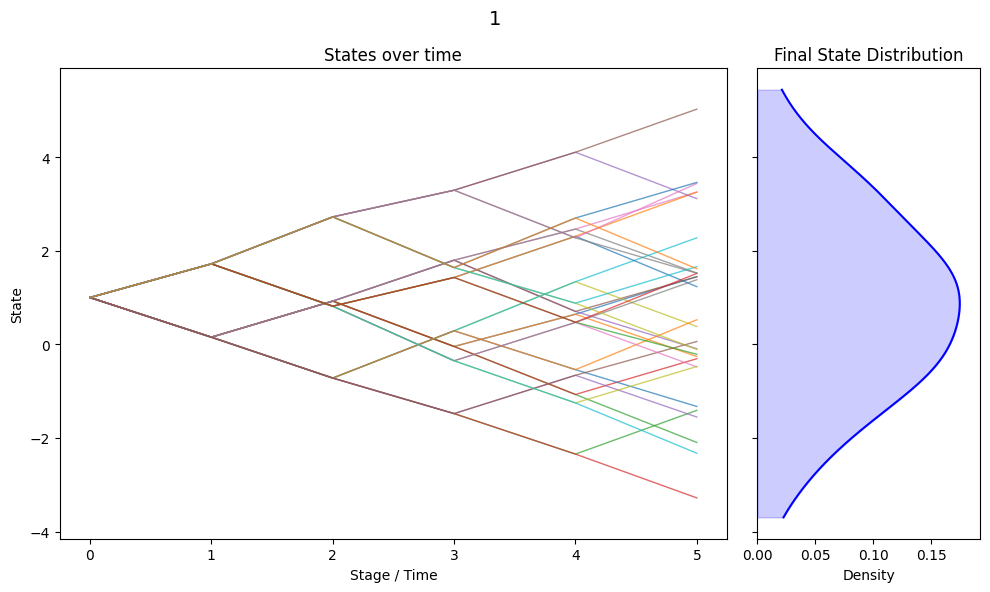

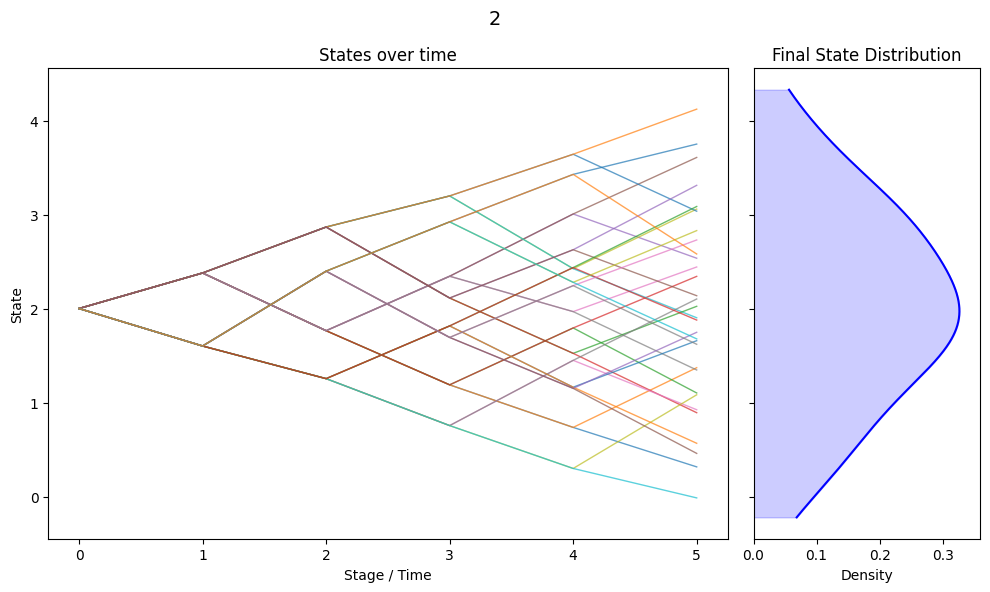

    POT Distance: 9.6644  Time: 0.06s


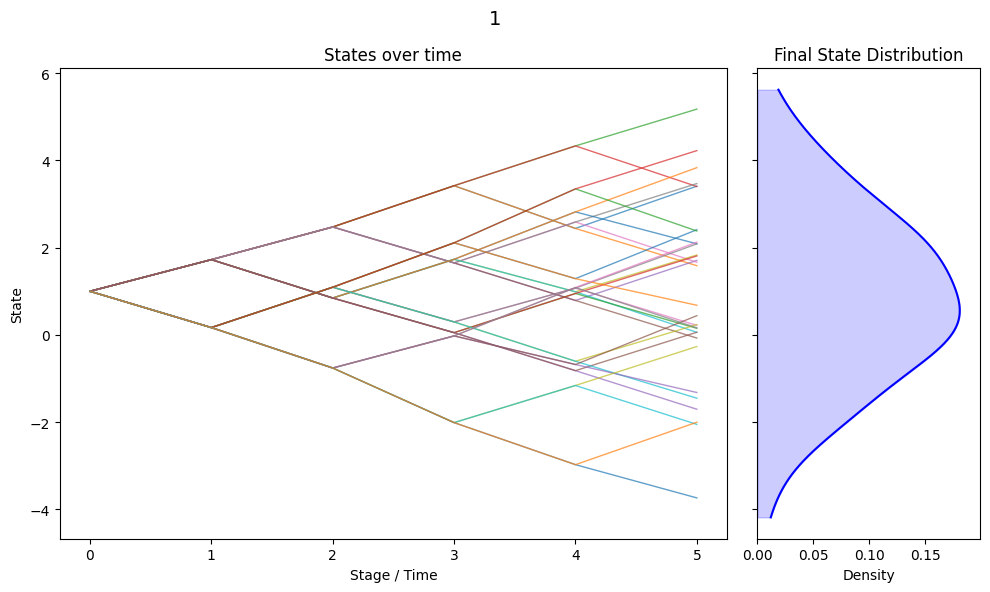

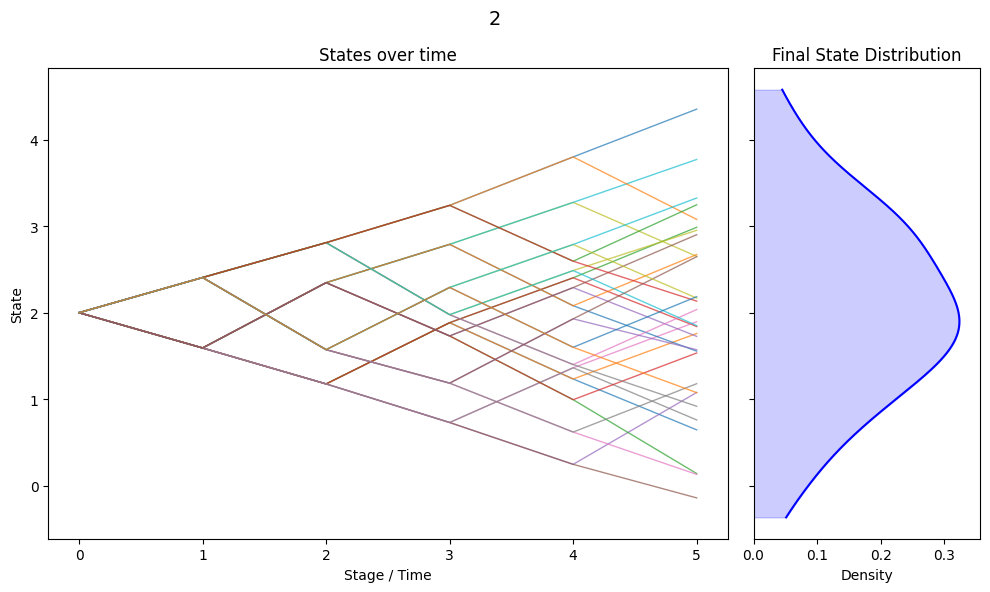

    POT Distance: 10.8255  Time: 0.05s


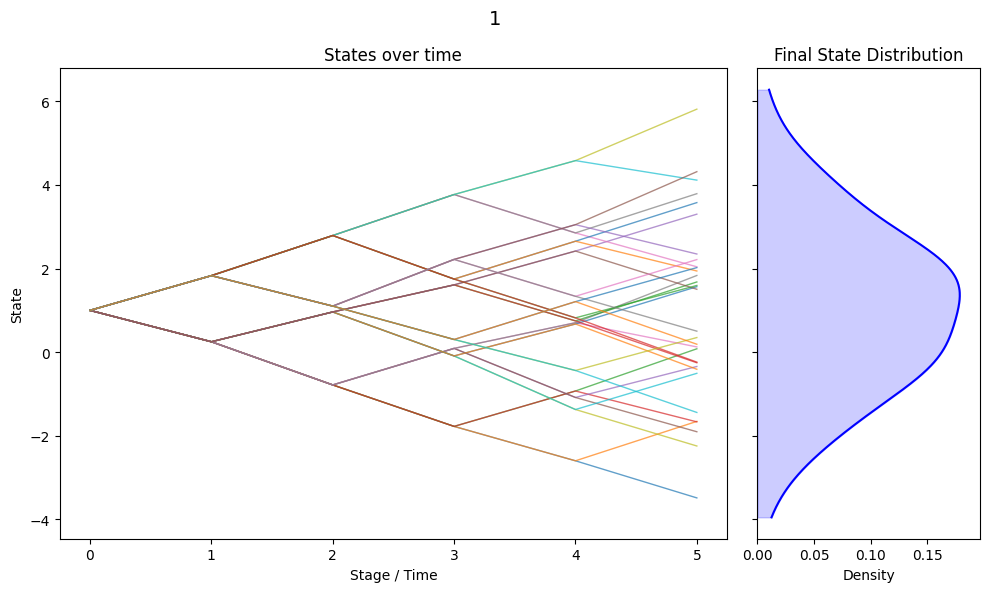

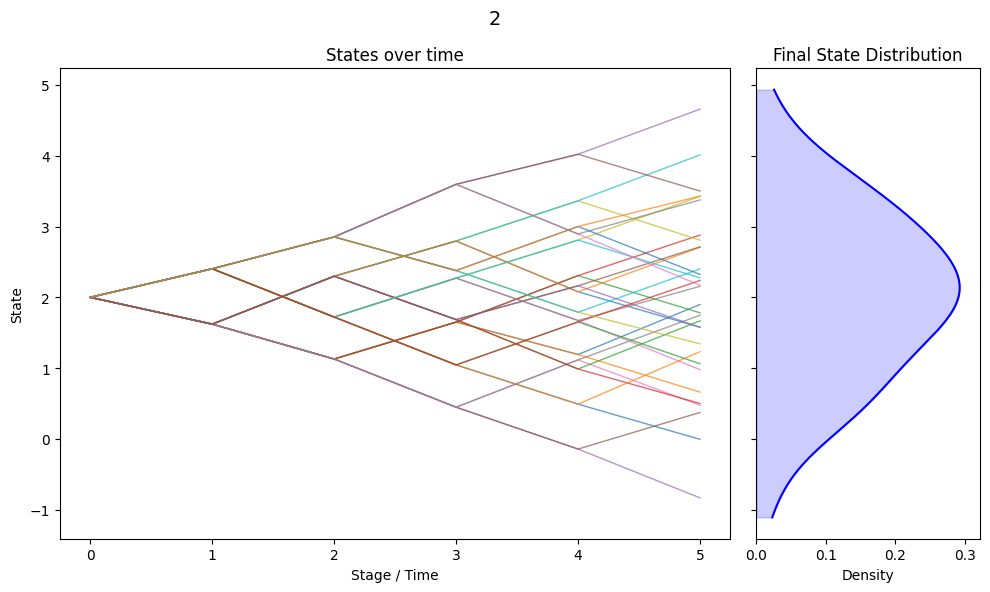

    POT Distance: 8.3593  Time: 0.05s


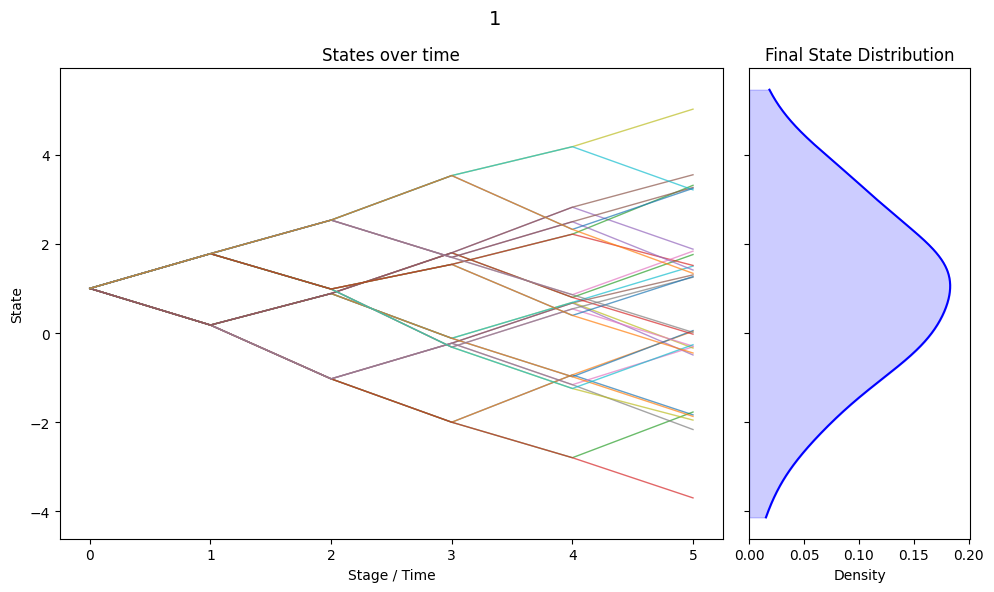

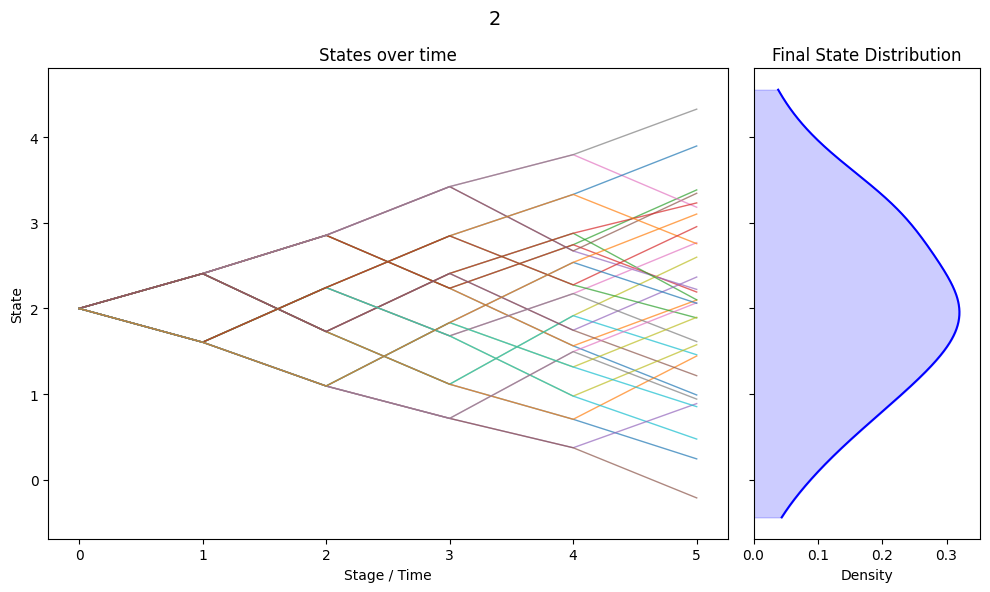

    POT Distance: 9.7197  Time: 0.06s
  POT mean (std) = 9.1065 (0.8889)
  POT avg time   = 0.058


In [5]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from CD_nonparam import *


def my_build_tree_cde_nonparam(
    T,
    init,
    samplepath_x,
    bandwidth_joint=0.5,
    bandwidth_marginal=0.5,
    sample_size_for_kmeans=200,
    n_leaf=2,
):
    """
    Builds a tree of depth T (i.e. T transitions, T+1 time steps) using:
      - KMeans clustering for the first transition (t == 0), and
      - A one-step conditional density estimator for subsequent transitions.

    For t == 0:
      - Cluster the values at time 1 (from samplepath_x) using KMeans with in_sample_size clusters.
      - Use the cluster centers as support points and the relative frequency counts as probabilities.
      - Create children by adding these support points to the root's value.

    For t > 0:
      - Prepare the data from time t to t+1 (i.e. columns t and t+1 of samplepath_x).
      - For each node at time t, let x0 be its value and call:
            f_cond = estimate_conditional_density_one_step(data, x0, bandwidth_joint, bandwidth_marginal, y_grid)
      - Normalize the estimated density on y_grid:
            est_weights = f_cond * dx
            est_weights = est_weights / np.sum(est_weights)
      - Compute sampling probabilities:
            sampling_prob = f_cond / np.sum(f_cond)
      - Sample sample_size_for_kmeans points from y_grid (reshaped to (-1,1)) using sampling_prob.
      - Run KMeans (with n_leaf clusters) on the sampled points.
      - Use the resulting cluster centers as support points and the cluster frequencies as weights.
      - Create children by adding these support points to the parent's value.

    Parameters:
      - T (int): Number of transitions (tree depth).
      - init (float): Initial value at the root.
      - samplepath_x (np.ndarray): Array of i.i.d. sample paths (shape: [num_paths, time_steps]).
      - device: PyTorch device.
      - in_sample_size (int): Parameter for KMeans at t==0.
      - n_iter (int): Number of iterations (not used in one-step estimation).
      - bandwidth_joint: Bandwidth for joint density in the one-step estimator.
      - bandwidth_marginal: Bandwidth for marginal density in the one-step estimator.
      - y_grid (np.ndarray): Grid of y values for evaluation.
      - dx (float): Grid spacing used in density normalization.
      - sample_size_for_kmeans (int): Number of points to sample from y_grid (default 200).
      - n_leaf (int): Number of clusters for KMeans in the one-step estimation step.

    Returns:
      - TreeNode: The root of the constructed tree.
    """
    # Create the root node.
    root = TreeNode(init)
    current_level = [root]

    # Loop over transitions (time steps).
    for t in range(T - 1):
        if t == 0:
            # For t == 0, cluster the values at time 1.
            samples = samplepath_x[:, t + 1].reshape(-1, 1)  # shape: (num_paths, 1)
            kmeans = KMeans(n_clusters=n_leaf, n_init=10).fit(samples)
            centers = np.squeeze(kmeans.cluster_centers_, axis=1)
            # Calculate probabilities based on cluster counts.
            _, counts = np.unique(kmeans.labels_, return_counts=True)
            probs = counts / np.sum(counts)
        else:
            # For t > 0, prepare the data for one-step density estimation.
            X = np.expand_dims(samplepath_x[:, t], axis=1)  # shape: (num_paths, 1)
            Y = np.expand_dims(samplepath_x[:, t + 1], axis=1)  # shape: (num_paths, 1)
            data = np.concatenate([X, Y], axis=1)  # shape: (num_paths, 2)

            y_min = np.min(Y) - 3
            y_max = np.max(Y) + 3
            y_grid = np.linspace(y_min, y_max, 800)
            dx = y_grid[1] - y_grid[0]

        next_level = []
        # Process each node in the current level.
        for node in current_level:
            if t == 0:
                # For t == 0, use the KMeans centers as support points.
                for i, center in enumerate(centers):
                    child_val = center
                    child_node = TreeNode(child_val)
                    node.add_child(child_node, probs[i])
                    next_level.append(child_node)
            else:
                # For t > 0, use the one-step conditional density estimator for each node.
                x0 = node.value
                # Estimate the conditional density f_cond on y_grid.
                f_cond = estimate_conditional_density_two_step(
                    data, x0, bandwidth_joint, bandwidth_marginal, y_grid
                )
                # Normalize the estimated density.
                est_weights = f_cond * dx
                est_weights = est_weights / np.sum(est_weights)
                # Compute sampling probabilities.
                sampling_prob = f_cond / np.sum(f_cond)
                # Sample points from y_grid according to sampling_prob.
                sample_points = np.random.choice(
                    y_grid, size=sample_size_for_kmeans, p=sampling_prob
                )
                sample_points = sample_points.reshape(-1, 1)
                # Cluster the sampled points via KMeans.
                kmeans = KMeans(n_clusters=n_leaf, n_init=10).fit(sample_points)
                centers = kmeans.cluster_centers_.flatten()
                # Determine weights for each cluster based on counts.
                _, counts = np.unique(kmeans.labels_, return_counts=True)
                kmeans_weights = counts / sample_size_for_kmeans
                # Create children nodes using these cluster centers.
                for i, center in enumerate(centers):
                    child_val = center
                    child_node = TreeNode(child_val)
                    node.add_child(child_node, kmeans_weights[i])
                    next_level.append(child_node)

        # Proceed to the next level.
        current_level = next_level

    return root


import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define common parameters
scale1 = 1
scale2 = 0.5
init_a, init_b = 1, 2
use_weights = 1
n_runs = 10

# Define sample path sizes for each time step
num_paths = 3000
# Bandwidth parameters for the density estimation (may need tuning)
bandwidth_joint = 0.5
bandwidth_marginal = 0.5

time_steps = 6


pot_times = []
final_result_pot = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for n in range(n_runs):

    sample_path_1 = generate_brownian_motion(
        num_paths=num_paths,
        time_steps=time_steps,
        x_init=init_a,
        scale=scale1,
        return_time=False,
    )
    sample_path_2 = generate_brownian_motion(
        num_paths=num_paths,
        time_steps=time_steps,
        x_init=init_b,
        scale=scale2,
        return_time=False,
    )

    tree1_root = my_build_tree_cde_nonparam(
        T=6,
        init=init_a,
        samplepath_x=sample_path_1,  # sample_path_2 should be a NumPy array of shape [num_paths, time_steps]
        n_leaf=2,
    )

    tree2_root = my_build_tree_cde_nonparam(
        T=6, init=init_b, samplepath_x=sample_path_2, n_leaf=2
    )

    visualize_big_tree(tree1_root, fig_size=(10, 6), title="1")
    visualize_big_tree(tree2_root, fig_size=(10, 6), title="2")

    max_depth = get_depth(tree1_root)
    start_time = time.time()
    distance_pot = compute_nested_distance(
        tree1_root,
        tree2_root,
        max_depth,
        method="solver_lp_pot",
        return_matrix=False,
        lambda_reg=0,
        power=2,
    )
    elapsed_time_pot = time.time() - start_time

    # Adjust distance by subtracting the initial difference in squares (if needed)
    distance_pot -= (init_a - init_b) ** 2

    final_result_pot.append(distance_pot)
    pot_times.append(elapsed_time_pot)
    print(f"    POT Distance: {distance_pot:.4f}  Time: {elapsed_time_pot:.2f}s")


mean_pot = np.mean(final_result_pot)
std_pot = np.std(final_result_pot)

mean_pot_time = np.mean(pot_times)
print("  POT mean (std) =", f"{mean_pot:.4f} ({std_pot:.4f})")
print("  POT avg time   =", f"{mean_pot_time:.3f}")